<a href="https://colab.research.google.com/github/fassaud/House-Price-Regression/blob/main/BUS_656_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8-whitegrid")

from sklearn.model_selection import KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

RANDOM_STATE = 42


### Dataset Creation

In [2]:
# Load the dataset
url = "https://raw.githubusercontent.com/fassaud/House-Price-Regression/refs/heads/main/test.csv"
test = pd.read_csv(url)

url = "https://raw.githubusercontent.com/fassaud/House-Price-Regression/refs/heads/main/train.csv"
train = pd.read_csv(url)

### Inspect Data

In [3]:
print("Train shape:", train.shape)
print("Test shape :", test.shape)
display(train.head())

Train shape: (1460, 81)
Test shape : (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Data Preperation

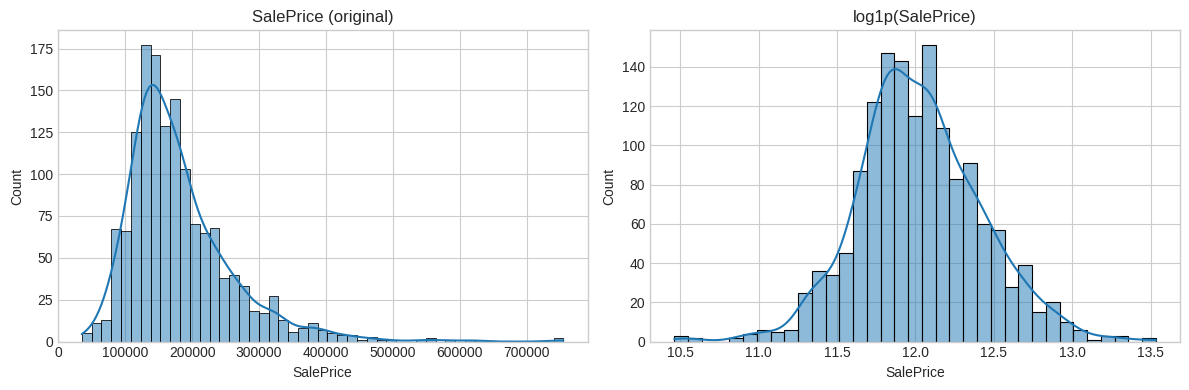

In [4]:
# Target distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(train["SalePrice"], kde=True, ax=ax[0])
ax[0].set_title("SalePrice (original)")

sns.histplot(np.log1p(train["SalePrice"]), kde=True, ax=ax[1])
ax[1].set_title("log1p(SalePrice)")
plt.tight_layout()
plt.show()

In [5]:
#missing values
missing = train.isna().mean().sort_values(ascending=False)
print("Columns with missing values (top 15):")
print(missing[missing > 0].head(15))

Columns with missing values (top 15):
PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
MasVnrType      0.597260
FireplaceQu     0.472603
LotFrontage     0.177397
GarageQual      0.055479
GarageFinish    0.055479
GarageType      0.055479
GarageYrBlt     0.055479
GarageCond      0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtCond        0.025342
dtype: float64


In [6]:
numeric_cols = train.select_dtypes(include=["int64", "float64"]).columns
corr_with_target = (
    train[numeric_cols]
    .corr()["SalePrice"]
    .sort_values(ascending=False)
)
print("Top correlations with SalePrice:")
print(corr_with_target.head(10))


Top correlations with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


In [7]:
#Train / target setup
y = np.log1p(train["SalePrice"])

In [8]:
# Drop SalePrice and Id from features
X = train.drop(columns=["SalePrice", "Id"])
X_test_full = test.drop(columns=["Id"])


In [9]:
#engineered_features
def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Total square footage of house
    for col in ["TotalBsmtSF", "1stFlrSF", "2ndFlrSF"]:
        if col not in df.columns:
            df[col] = 0  # just in case

    df["TotalSF"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]

    # Age at sale (built & remodeled)
    for col in ["YrSold", "YearBuilt", "YearRemodAdd"]:
        if col not in df.columns:
            df[col] = df[col].fillna(df[col].median())

    df["AgeBuilt"] = df["YrSold"] - df["YearBuilt"]
    df["AgeRemod"] = df["YrSold"] - df["YearRemodAdd"]

    # Total bathrooms
    for col in ["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"]:
        if col not in df.columns:
            df[col] = 0

    df["TotalBath"] = (
        df["FullBath"]
        + 0.5 * df["HalfBath"]
        + df["BsmtFullBath"]
        + 0.5 * df["BsmtHalfBath"]
    )

    # Remodeled flag
    df["IsRemodeled"] = (df["YearRemodAdd"] != df["YearBuilt"]).astype(int)

    # Simple binary features
    df["HasPool"] = (df.get("PoolArea", 0) > 0).astype(int)
    df["Has2ndFloor"] = (df.get("2ndFlrSF", 0) > 0).astype(int)

    # Interaction term between quality and living area
    if "OverallQual" in df.columns and "GrLivArea" in df.columns:
        df["OverallQual_GrLiv"] = df["OverallQual"] * df["GrLivArea"]

    return df

X_fe = add_engineered_features(X)
X_test_fe = add_engineered_features(X_test_full)

print("Engineered features added. New shape:", X_fe.shape)

Engineered features added. New shape: (1460, 87)


In [10]:
#Preprocessing pipeline

numeric_features = X_fe.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_fe.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


### Select Model

In [11]:
#LASSO
lasso = LassoCV(
    alphas=np.linspace(0.0005, 0.01, 30),
    cv=5,
    random_state=RANDOM_STATE,
    max_iter=10000,
)

In [12]:
#Gradient Boosting Regressor
gbr = GradientBoostingRegressor(
    random_state=RANDOM_STATE,
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=3,
    subsample=0.8,
    min_samples_leaf=5,
)


In [13]:
#Random Forest
rf = RandomForestRegressor(
    random_state=RANDOM_STATE,
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=2,
    n_jobs=-1,
)



In [14]:
models = {
    "LASSO": lasso,
    "GradientBoosting": gbr,
    "RandomForest": rf,
}


In [ ]:
cv_results = {}

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for name, model in models.items():
    pipe = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", model),
        ]
    )

    # scoring is RMSE on log(SalePrice)
    neg_rmse_scores = cross_val_score(
        pipe,
        X_fe,
        y,
        cv=kf,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
    )
    rmse_scores = -neg_rmse_scores

    cv_results[name] = rmse_scores

    print(f"Model: {name}")
    print(f"  CV RMSE (log target) mean: {rmse_scores.mean():.5f}")
    print(f"  CV RMSE (log target) std : {rmse_scores.std():.5f}")
    print("-" * 40)


Model: LASSO
  CV RMSE (log target) mean: 0.14196
  CV RMSE (log target) std : 0.04300
----------------------------------------


In [ ]:
#Pick best model
mean_scores = {name: scores.mean() for name, scores in cv_results.items()}
best_name = min(mean_scores, key=mean_scores.get)
best_score = mean_scores[best_name]

print(f"Best model: {best_name} with mean CV RMSE = {best_score:.5f}")


In [ ]:
best_model = models[best_name]

final_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", best_model),
    ]
)

final_pipe.fit(X_fe, y)


### Create Submission

In [ ]:
#create submission
test_pred_log = final_pipe.predict(X_test_fe)
test_pred = np.expm1(test_pred_log)  # invert log1p

submission = pd.DataFrame(
    {
        "Id": test["Id"],
        "SalePrice": test_pred,
    }
)

submission.to_csv("submission.csv", index=False)
print("submission.csv created!")
